# Breast Cancer 

En este Notebook vamos a resolver un problema de **clasificación con ML**.

El objetivo es entrenar un modelo que sea capaz de predecir si la persona va a tener cáncer de pecho o no.

**Imports necesarios para el proyecto**

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import joblib
import sys
sys.path.append('../utils')
import warnings

from helpers import load_data, split_data, evaluate_model, create_pipeline


**Configuraciones del Notebook**

In [48]:
%matplotlib inline
warnings.filterwarnings('ignore')

El dataset se ha obtenido en: https://github.com/selva86/datasets

Mostramos estadísticos y target

In [49]:
df = load_data('../data_sample/BreastCancer.csv')

In [50]:
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               699 non-null    int64  
 1   Cl.thickness     699 non-null    int64  
 2   Cell.size        699 non-null    int64  
 3   Cell.shape       699 non-null    int64  
 4   Marg.adhesion    699 non-null    int64  
 5   Epith.c.size     699 non-null    int64  
 6   Bare.nuclei      683 non-null    float64
 7   Bl.cromatin      699 non-null    int64  
 8   Normal.nucleoli  699 non-null    int64  
 9   Mitoses          699 non-null    int64  
 10  Class            699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


In [52]:
df.describe()

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [53]:
# Basic info
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Dataset shape: (699, 11)

Data types:
 Id                   int64
Cl.thickness         int64
Cell.size            int64
Cell.shape           int64
Marg.adhesion        int64
Epith.c.size         int64
Bare.nuclei        float64
Bl.cromatin          int64
Normal.nucleoli      int64
Mitoses              int64
Class                int64
dtype: object

Missing values:
 Id                  0
Cl.thickness        0
Cell.size           0
Cell.shape          0
Marg.adhesion       0
Epith.c.size        0
Bare.nuclei        16
Bl.cromatin         0
Normal.nucleoli     0
Mitoses             0
Class               0
dtype: int64


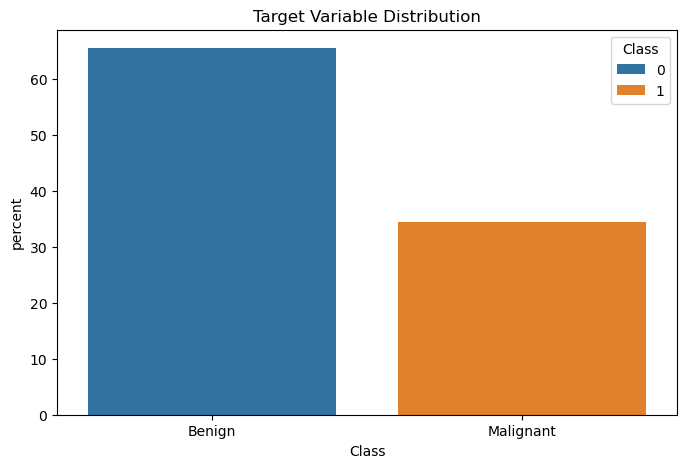

In [54]:
# Target distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Class', data=df, stat="percent", hue='Class')
plt.title('Target Variable Distribution')
plt.xticks(ticks=[0,1], labels=['Benign', 'Malignant'])
plt.show()

Dividimos en train y test usando la función split_data

In [55]:
X_train, X_test, y_train, y_test = split_data(df, 'Class')

Creamos los modelos con hiperparámetros usando la función create_pipeline

In [56]:
# Baseline models
models = {
    "Logistic Regression": create_pipeline(LogisticRegression(penalty="l2", random_state=42,
                                                               max_iter=100, C=0.1, class_weight="balanced")),
    
    "Random Forest": create_pipeline(RandomForestClassifier(random_state=42, max_depth=5,
                                                             min_samples_split=10, n_estimators=100, class_weight="balanced")),
    
    "SVM": create_pipeline(SVC(probability=True, random_state=42,
                                C=1, kernel="linear", class_weight="balanced"))
}

Iteramos sobre los modelos y los entrenamos uno a uno.

Guardamos los resultados en un DataFrame

In [57]:
# Iterate over the models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)

# Compare results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values('ROC-AUC', ascending=False))



Training Logistic Regression...

Training Random Forest...

Training SVM...

Model Comparison:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
SVM                  0.957143   0.937500  0.937500  0.937500  0.994792
Logistic Regression  0.964286   0.938776  0.958333  0.948454  0.994339
Random Forest        0.964286   0.921569  0.979167  0.949495  0.987998


Obtenemos el mejor modelo que vamos a entrenar

In [58]:
# Get the best model 
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]
print(f"\nMejor modelo base: {best_model_name} (Accuracy): {results_df.loc[best_model_name, 'Accuracy']:.3f})")


Mejor modelo base: Logistic Regression (Accuracy): 0.964)


In [59]:
# Hyperparameters
param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2', 'none'],
        "classifier__max_iter": [50, 100, 200],
        "classifier__class_weight": ["balanced"]
    },
    "Random Forest": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 8],
        "classifier__class_weight": ["balanced" ] 
    },
    "SVM": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf', 'linear'],
        "classifier__class_weight": ["balanced"]
    }
}

Aplicamos Grid_Search al mejor modelo

In [60]:
# Hyperparameters optimizer
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grids[best_model_name],
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Bare.nuclei'])])),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(C=0.1,
                                                           class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__class_weight': ['balanced'],
                         'classifier__max_iter': [50, 100, 200],
                         'classifier__penalty': ['l2', 'none']},
             scoring='accuracy', verbose=1)

Obtenemos el mejor estimador de las posibles combinaciones de hiperparámetros y evaluamos el modelo con la función evaluate_model

In [61]:
# Get the best estimator and evaluate the model
optimized_model = grid_search.best_estimator_
optimized_metrics = evaluate_model(optimized_model, X_test, y_test)
print(f"\nModelo optimizado ({best_model_name}) - (Accuracy): {optimized_metrics['Accuracy']:.3f}")


Modelo optimizado (Logistic Regression) - (Accuracy): 0.964


Guardamos el mejor modelo en la carpeta 'src/models/'

In [62]:
# ## Paso 7: Save Best Model
joblib.dump(optimized_model, '../models/best_model.joblib')
print("Model saved successfully!")

Model saved successfully!
